In [1]:
# imPORT LIBRARIES 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import pi, sqrt
import handcalcs.render
import pandas as pd
import json 
# !pip install handcalcs

In [2]:
# CONFIGURATIONS
#help(handcalcs.set_option)
handcalcs.set_option("latex_block_start", "$")
handcalcs.set_option("latex_block_end", "$")
handcalcs.set_option("math_environment_end", "aligned")
handcalcs.set_option("use_scientific_notation",True)

## Inputs and claculated parameters

In [3]:
with open("04_outputs/inp_datas.json", "r", encoding="utf-8") as f:
    inp_datas = json.load(f)
print("Input datas:")
print("="*20)
display(inp_datas)

with open("04_outputs/out_results.json", "r", encoding="utf-8") as f:
    out_datas = json.load(f)
print("Output datas:")
print("="*20)
display(out_datas)


# Load variables 
for key, value in inp_datas.items():
    globals()[key] = value
for key, value in out_datas.items():
    globals()[key] = value

Input datas:


{'V_In_min': 360.0,
 'V_In_nom': 380.0,
 'V_In_max': 400.0,
 'Vo_min': 42.0,
 'Vo_nom': 48.0,
 'Vo_max': 54.0,
 'Power': 1200.0,
 'f_nom': 100000.0}

Output datas:


{'Lnc': 3.0,
 'Qec': 0.55,
 'Cr_nF': 116.209,
 'n': 4.0,
 'Lr_uH': 21.797,
 'Lm_uH': 65.392,
 'fsw_min': 60170.0,
 'fsw_max': 156220.0,
 'Im_rms': 6.992,
 'Io': 25.0,
 'Ioe_rms': 7.636,
 'Ios_rms': 30.545,
 'Ir_rms': 10.354,
 'L_second_uH': 4.087,
 'Re_nom': 24.901,
 'Re_110': 22.637,
 'Cr': 1.16209e-07,
 'Lr': 2.1796999999999998e-05,
 'Lm': 6.539199999999999e-05}

## Output capacitor Co

For a resistive load, the output capacitor is determined by
$$
C_o \geq C_{o_{min}} = \frac{I_o}{8 \cdot f_{sw} \cdot \Delta V_{out}}
$$

Where:

- $C_o$ : Output capacitance (Farads, F)  
- $I_o$ : Output load current (Amperes, A)  
- $f_{sw}$ : Switching frequency of the converter (Hertz, Hz)  
- $\Delta V_{out}$ : Maximum allowed output voltage ripple (Volts, V)  
$$ESR_{max} = \frac{\Delta V_{out}}{I_{rect\_peak}} = \frac{\Delta V_{out}}{\frac{\pi}{4} \cdot I_o\cdot{2}}  $$
$$I_{C_o} = I_o \sqrt{\frac{\pi^2}{8} - 1}$$

Where:

- $I_{C_o}$ : RMS current of the capacitor @ f_sw = f_nom  
 
See page 26, 27 [\[1\]](#referencesID1).
<br> By default, you can found all formula of this chapeter in the same ref 

In [ ]:
%%render
Io # A
f_nom # Hz
DV = 0.25 # vpp
Co_min_uF = 1e6*Io/(8*f_nom*DV ) # uF
ESR_max_m = 1e3*DV /(Io*pi/2) # mΩ 
I_Co= Io*sqrt(pi**2/8-1) # Arms

In [5]:
# https://www.mouser.fr/ProductDetail/EPCOS-TDK/B40910A8127M000?qs=HoCaDK9Nz5cacmF7ifyf%252BQ%3D%3D
# B40910A8127M000


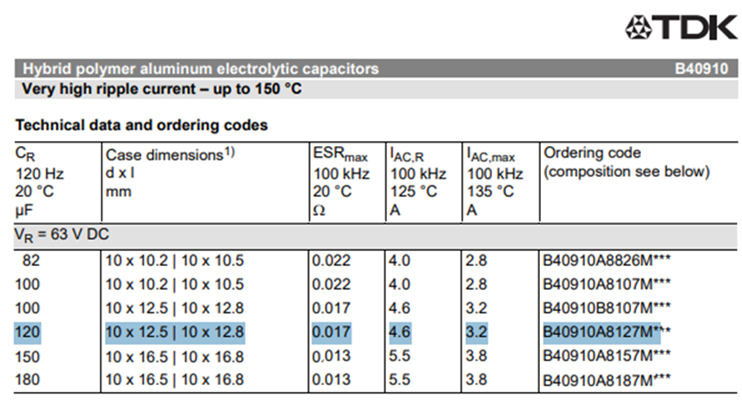

In [22]:
%%render 
#4 parallels capascitor
Nb_capa= 4
C_capa = 120 # uF
C_eq = C_capa*Nb_capa # uF > 125uF
ESR_capa= 17 # mOhm @ 100kHz

ESR_eq = ESR_c/Nb_capa # < 6.36m OK
Icapa_max = 4.6
Ieq_max = Icapa_max *Nb_capa  #  @ 125°C 100kHz > 12.086Arms

<IPython.core.display.Latex object>

## Transformer design

In [6]:
params = ['n',  'Lm_uH', 'fsw_min', 'fsw_max', 'Ir_rms', 'Im_rms', 'Ioe_rms', 'Ios_rms', 'L_second_uH']

dic_transfo= {x:out_datas[x] for x in params}
Al = out_datas["Lm_uH"]/out_datas["n"]**2
dic_transfo["Al_uH"]= Al
print("Transormer parameters:")
display(dic_transfo)

Transormer parameters:


{'n': 4.0,
 'Lm_uH': 65.392,
 'fsw_min': 60170.0,
 'fsw_max': 156220.0,
 'Ir_rms': 10.354,
 'Im_rms': 6.992,
 'Ioe_rms': 7.636,
 'Ios_rms': 30.545,
 'L_second_uH': 4.087,
 'Al_uH': 4.087}

where: 
* `n`: Transformer turns ratio $ n = N_p / N_s $
* `N_p = n` since `N_s= 1`
* `Lm_uH`: Magnetizing inductance $ L_m $, sets magnetizing current and contributes to gain shaping
* `fsw_min`: Minimum switching frequency $ f_{sw,\min} $, corresponds to maximum load
* `fsw_max`: Maximum switching frequency $ f_{sw,\max} $, corresponds to no-load
* `Ir_rms`: RMS current in the resonant tank inductor $ I_r = \sqrt{I_m^2 + I_{oe}^2} $
* `Im_rms`: RMS magnetizing current $ I_m $, flows through $ L_m $
* `Ioe_rms`: RMS transferred current in the primary winding, represents reflected load current
* `Ios_rms`: RMS current in the secondary winding $ I_{os} = I_{oe} \cdot n $
* `Al_uH`: Inductance per turn squared $ A_L $, used to compute turns: $ L = A_L \cdot N^2 $


**Bpeak formula**

$$
B_{peak} = \frac{L_m \cdot Im_{peak}}{N_p \cdot A_e}= \frac{L_m \cdot \sqrt{2} \cdot  Im_{rms}}{N_p \cdot A_{emin}}
$$

Where
- `A_e` = effective core area (in m²)
- `A_emin` = effective minimum core area (in m²)
- `N_p` = primary turnes


In [7]:
%%render 
Al_nH= Al*1e3 # nH

<IPython.core.display.Latex object>

**ELP 43/10/28 core**

In [8]:
%%render
Lm_uH
Np= n # turns 
Ae = 225 # mm2 see datasheet ELP 43/10/28
Aemin = 217 # mm2 see datasheet ELP 43/10/28
Im_rms # Arms
B_peak = 1e3*Lm*sqrt(2)*Im_rms/(Np*Aemin*1e-6) # mT > Bs= 250mT NOK

<IPython.core.display.Latex object>

In [9]:
%%tex 
B_peak = Lm*sqrt(2)*Im_rms/(Np*Aemin) 

$
\begin{aligned}
B_{peak} &= \mathrm{Lm} \cdot \sqrt { 2 } \cdot \frac{ \mathrm{Im}_{rms} }{ \mathrm{Np} \cdot \mathrm{Aemin} }  = 0.000 \cdot \sqrt { 2 } \cdot \frac{ 6.992 }{ 4.000 \cdot 217 } &= 0.000  
\end{aligned}
$


Since the formulat of peak flux density is $
\begin{aligned}
B_{peak} = \mathrm{Lm} \cdot \sqrt { 2 } \cdot \frac{ \mathrm{Im}_{rms} }{ \mathrm{Np} \cdot \mathrm{Aemin} }   
\end{aligned}
$
We can reduct the peak by reducing the current or by reducing Lm or by increasing Np 

- **Formula (in terms of \(A_L\) and \(A_L'\)):**

  $$
  l_g = \frac{\mu_0 \cdot \mu_i \cdot A_e}{A_L'} - l_e
  $$

- **Explanations:**

  - \(l_g\): *air-gap length* (in meters) — the total non-magnetic gap you introduce.
  - \(\mu_0\): *vacuum permeability*, \(4\pi \times 10^{-7}\ \mathrm{H/m}\).
  - \(\mu_i\): *initial (ungapped) relative permeability*, unitless, from the core’s datasheet.
  - \(A_e\): *effective cross-sectional area* of the core (in m²).
  - \(A_L'\): *desired inductance-per-turn-squared* (in H per turn², i.e., \(L/N^2\)) after gapping.
  - \(l_e\): *effective magnetic path length* of the core (in meters), from datasheet.


$$
A_{L}' = \frac{A_L}{1 + \mu_r \,\frac{L_g}{L_e}}
$$

$$
L_g = \frac{L_e}{\mu_r} \left( \frac{A_L}{A_L'} - 1 \right)
$$

Where:
- \( A_{L}' \) : the corrected inductance factor (in nH or µH), after introducing the air gap
- \( A_L \) : the initial inductance factor provided by the core manufacturer (in nH or µH)
- \( l_g \) : the air gap length (in mm)
- \( L_e \) : the effective magnetic path length of the core (in mm)

This equation accounts for the effect of the air gap on the inductance. Increasing the air gap reduces the effective permeability, and thus reduces \( A_{L}' \).


In [47]:
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_22_6_16.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_32_6_20.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_38_8_25.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_43_10_28.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_58_11_38.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_64_10_50.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/e_70_33_32.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/e_80_38_40.pdf

| Core         | Window Depth (mm) | Width (mm) | AL Range (nH) | Materials                     |
| ------------ | ----------------- | ---------- | ------------- | ----------------------------- |
| ELP 22/6/16  | 6.0               | 16.0       | 125 – 6100    | N49–PC200, N87, N92, N97      |
| ELP 32/6/20  | 6.35              | 20.35      | 440 – 7550    | N49–PC200, N87, N97           |
| ELP 38/8/25  | 8.25              | 25.4       | 400 – 8800    | N49–PC200, N87, N92, N95, N97 |
| ELP 43/10/28 | 9.5–10            | 27.9       | 355 – 9000    | N49–PC200, N87, N92, N95, N97 |


In [48]:
dfcore = pd.DataFrame([
{"core":"ELP 43/10/28 with I 43/4/28 N87",
 
 "Al_nH":7300, 
"Aemin":217,
"Le":61.6 ,
"µe":1560 ,
"K1":390,
"K2":-0.784, 
"K3_25":621, 
"K4_25":-0.796,
"Bsat": 300},

{"core":"ELP 58/11/38 with I 58/4/38 N87",
 "Al_nH":7400, 
"Aemin":308,
"Le": 80.7 ,
"µe":1540 ,
"K1":591,
"K2":-0.685, 
"K3_25":791, 
"K4_25":-0.796,
"Bsat": 300},



{"core":"ELP 64/10/50 with I 64/5/50 N87",
"Al_nH": 14000, 
"Aemin":518,
"Le": 69.7,
"µe": 1450, 
"K1":835,
"K2":-0.790, 
"K3_25":1316, 
"K4_25":-0.796, 
"Bsat":300},

{"core":"ELP 64/10/50 with ELP 64/10/50 N95",
 "Al_nH":15500, 
"Aemin":518,
"Le": 79,
"µe": 1880, 
"Bsat":320},

{"core":"ELP 102/20/38 with I 102/7/38 N87",
"Aemin":524.5,
}

])

for i in range (len(dfcore)):
    dic  =dfcore.loc[i,:].to_dict()
    Aemin = dic['Aemin']
    K1 = dic["K1"]
    K2 = dic["K2"]
    K3_25 = dic["K3_25"]
    K4_25 = dic["K4_25"]
    Al_nH0 = dic["Al_nH"]
    Le = dic["Le"]
    µe = dic["µe"]
    s_mm= (Al_nH/K1)**(1/K2) # airgap
    e_mm= Le *(Al_nH0/Al_nH-1)/µe
    I_dc = (0.9*Al_nH/K3_25)**(1/K4_25)
    B_peak = 1e3*Lm*sqrt(2)*Im_rms/(Np*Aemin*1e-6)
    dfcore.loc[i,"s_mm"]=s_mm
    dfcore.loc[i,"e_mm"]=e_mm
    dfcore.loc[i,"s_div_e"]=s_mm/e_mm
  
    dfcore.loc[i,"B_peak"]=B_peak
    dfcore.loc[i,"Idc_25"]=I_dc
    dfcore.loc[i,"Bpeak_inf_Bsat"]=dic["Bsat"]>B_peak
dfcore

,core,Al_nH,Aemin,Le,µe,K1,K2,K3_25,K4_25,Bsat,s_mm,e_mm,s_div_e,B_peak,Idc_25,Bpeak_inf_Bsat
0,ELP 43/10/28 with I 43/4/28 N87,7300.0,217.0,61.6,1560.0,390.0,-0.784,621.0,-0.796,300.0,0.358383,0.291128,1.231015,744.940031,0.745336,False
1,ELP 58/11/38 with I 58/4/38 N87,7400.0,308.0,80.7,1540.0,591.0,-0.685,791.0,-0.796,300.0,0.566860,0.392360,1.444745,524.844113,1.010109,False
2,ELP 64/10/50 with I 64/5/50 N87,14000.0,518.0,69.7,1450.0,835.0,-0.790,1316.0,-0.796,300.0,0.946761,0.723787,1.308066,312.069472,1.914725,False
3,ELP 64/10/50 with ELP 64/10/50 N95,15500.0,518.0,79.0,1880.0,NaN,NaN,NaN,NaN,320.0,NaN,0.705019,NaN,312.069472,NaN,True
4,ELP 102/20/38 with I 102/7/38 N87,NaN,524.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.202072,NaN,False


In [49]:
dic_trans_core= dfcore[dfcore.core=="ELP 64/10/50 with I 64/5/50 N87"].iloc[0,:].to_dict()
keys = ['core', 'Al_nH', 'Aemin', 'Le', 'µe', 'Bsat', 's_mm' , 'B_peak']
dic_trans_core = {k:dic_trans_core[k] for k in keys}
dic_trans_core 

{'core': 'ELP 64/10/50 with I 64/5/50 N87',
 'Al_nH': 14000.0,
 'Aemin': 518.0,
 'Le': 69.7,
 'µe': 1450.0,
 'Bsat': 300.0,
 's_mm': 0.9467606572636822,
 'B_peak': 312.06947242700016}

## Lr design 

In [62]:
params = ['Lr_uH', 'fsw_min', 'fsw_max', 'Ir_rms']

dic_Lr= {x:out_datas[x] for x in params}
print("Transormer parameters:")
display(dic_Lr)

Transormer parameters:


{'Lr_uH': 21.797, 'fsw_min': 60170.0, 'fsw_max': 156220.0, 'Ir_rms': 10.354}

In [81]:
dfcore = pd.DataFrame([
{"core":"ELP 22/6/16 with I 22/2.5/16 N87",
 "Al_nH":5200, 
"Aemin":77.9,
 "Bsat": 300,
 "K1": 134, 
 "K2": -0.806, 
 "s_lims":[0.1,1.5]
},

{"core":"ELP 32/6/20 with I 32/3/20 N87", 
  "Al_nH": 6300, 
"Aemin":128, 
  "Bsat": 300,
 "K1":234 , 
 "K2":-0.777,
  "s_lims":[0.1,1.5]
},

{"core":"ELP 43/10/28 with I 43/4/28 N87", 
  "Al_nH": 8500, 
"Aemin":217, 
  "Bsat": 300,
 "K1":390 ,
 "K2": -0.784,
"s_lims":[0.1,2]
},


{"core":"ELP 58/11/38 with I 58/4/38 N87", 
  "Al_nH": 8400, 
"Aemin":308, 
  "Bsat": 300,
 "K1": 591 ,
 "K2":-0.685,  
   "s_lims":[0.1,1.5]
}


    


])
dfcore

,core,Al_nH,Aemin,Bsat,K1,K2,s_lims
0,ELP 22/6/16 with I 22/2.5/16 N87,5200,77.9,300,134,-0.806,"[0.1, 1.5]"
1,ELP 32/6/20 with I 32/3/20 N87,6300,128.0,300,234,-0.777,"[0.1, 1.5]"
2,ELP 43/10/28 with I 43/4/28 N87,8500,217.0,300,390,-0.784,"[0.1, 2]"
3,ELP 58/11/38 with I 58/4/38 N87,8400,308.0,300,591,-0.685,"[0.1, 1.5]"


In [82]:
dic_Lr

{'Lr_uH': 21.797, 'fsw_min': 60170.0, 'fsw_max': 156220.0, 'Ir_rms': 10.354}

In [97]:
Ir_rms = dic_Lr['Ir_rms']
Lr = dic_Lr['Lr_uH']*1e-6

arr=[]
for n in range(1,9):
    for i in range(len(dfcore)):
        Aemin = dfcore.loc[i,"Aemin"]
        K1 = dfcore.loc[i,"K1"]
        K2 = dfcore.loc[i,"K2"]
        Al_nH_core = dfcore.loc[i,"Al_nH"]
        core = dfcore.loc[i,"core"]
        s_lims= dfcore.loc[i,"s_lims"]
        Al_nH = 1000*dic_Lr["Lr_uH"]/n**2
        if Al_nH < Al_nH_core: 
            s_mm= (Al_nH/K1)**(1/K2)
            s_valide = s_mm>s_lims[0] and  s_mm<s_lims[1]
        else:
            s_mm= None 
            s_valide= None
        
        error = 100*(Al_nH_cal-Al_nH)/Al_nH
        
        B_peak = 1e3*Ir_rms*Lr*sqrt(2)/(n*Aemin*1e-6)
        if (s_mm is not None or abs(error)<10) and s_valide:
            arr.append({"core":core, "N":n, #"Al_nH_cal": Al_nH_cal, 
                        "Al_nH_target": Al_nH, 
                        #"Al_error":error, 
                        "B_peak":B_peak, "Bsat":dfcore.loc[i, "Bsat"], "s_mm":s_mm,
                       "s_lims":s_lims#, "s_valide":s_valide
                       })
dfLr=pd.DataFrame(arr).sort_values("B_peak")
dfLr

,core,N,Al_nH_target,B_peak,Bsat,s_mm,s_lims
10,ELP 58/11/38 with I 58/4/38 N87,6,605.472222,172.710172,300,0.965299,"[0.1, 1.5]"
16,ELP 43/10/28 with I 43/4/28 N87,8,340.578125,183.852763,300,1.188669,"[0.1, 2]"
6,ELP 58/11/38 with I 58/4/38 N87,5,871.880000,207.252206,300,0.566860,"[0.1, 1.5]"
13,ELP 43/10/28 with I 43/4/28 N87,7,444.836735,210.117444,300,0.845517,"[0.1, 2]"
9,ELP 43/10/28 with I 43/4/28 N87,6,605.472222,245.137018,300,0.570611,"[0.1, 2]"
3,ELP 58/11/38 with I 58/4/38 N87,4,1362.312500,259.065257,300,0.295479,"[0.1, 1.5]"
5,ELP 43/10/28 with I 43/4/28 N87,5,871.880000,294.164421,300,0.358383,"[0.1, 2]"
15,ELP 32/6/20 with I 32/3/20 N87,8,340.578125,311.687888,300,0.616904,"[0.1, 1.5]"
0,ELP 58/11/38 with I 58/4/38 N87,3,2421.888889,345.420343,300,0.127568,"[0.1, 1.5]"
12,ELP 32/6/20 with I 32/3/20 N87,7,444.836735,356.214729,300,0.437468,"[0.1, 1.5]"


In [100]:
m1=dfLr.core == "ELP 58/11/38 with I 58/4/38 N87"
m2=dfLr.N == 4
dfLr[m1 & m2]

,core,N,Al_nH_target,B_peak,Bsat,s_mm,s_lims
3,ELP 58/11/38 with I 58/4/38 N87,4,1362.3125,259.065257,300,0.295479,"[0.1, 1.5]"


## Resonanat capacitor

In [43]:
%%render 
Cr_nF
V_In_max
fsw_min

<IPython.core.display.Latex object>

In [41]:
%%render 
X_Cr= 1/(2*pi*fsw_min*Cr_nF*1e-9) # Ohm 
V_Cr= Ir_rms*X_Cr # v
V_Cr_rms= sqrt((V_In_max/2)**2+V_Cr**2) # vrms

<IPython.core.display.Latex object>

In [46]:
{
"Cr_nF": Cr_nF, 
"V_In_max": V_In_max, 
"fsw_min":fsw_min, 
"V_Cr_rms":V_Cr_rms,
"Ir_rms":Ir_rms, 
}

{'Cr_nF': 116.209,
 'V_In_max': 400.0,
 'fsw_min': 60170.0,
 'V_Cr_rms': 309.09776282552184,
 'Ir_rms': 10.354}

In [ ]:
# https://www.mouser.es/ProductDetail/EPCOS-TDK/B32672L1333J?qs=vht8qxFUkGz11LfwwLq5EA%3D%3D
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

In [58]:
B32672L1333 = [6.2, 6.8, 8.2, 10.0, 12.0, 15.0, 22.0, 33.0, 47.0, 56.0, 68.0]
print(Cr_nF)
for c in B32672L1333: 
    print(c, Cr_nF/c, round(Cr_nF/c), round(Cr_nF/c)*c)

116.209
6.2 18.743387096774192 19 117.8
6.8 17.089558823529412 17 115.6
8.2 14.171829268292685 14 114.79999999999998
10.0 11.6209 12 120.0
12.0 9.684083333333334 10 120.0
15.0 7.7472666666666665 8 120.0
22.0 5.2822272727272725 5 110.0
33.0 3.5214848484848487 4 132.0
47.0 2.472531914893617 2 94.0
56.0 2.0751607142857145 2 112.0
68.0 1.7089558823529412 2 136.0


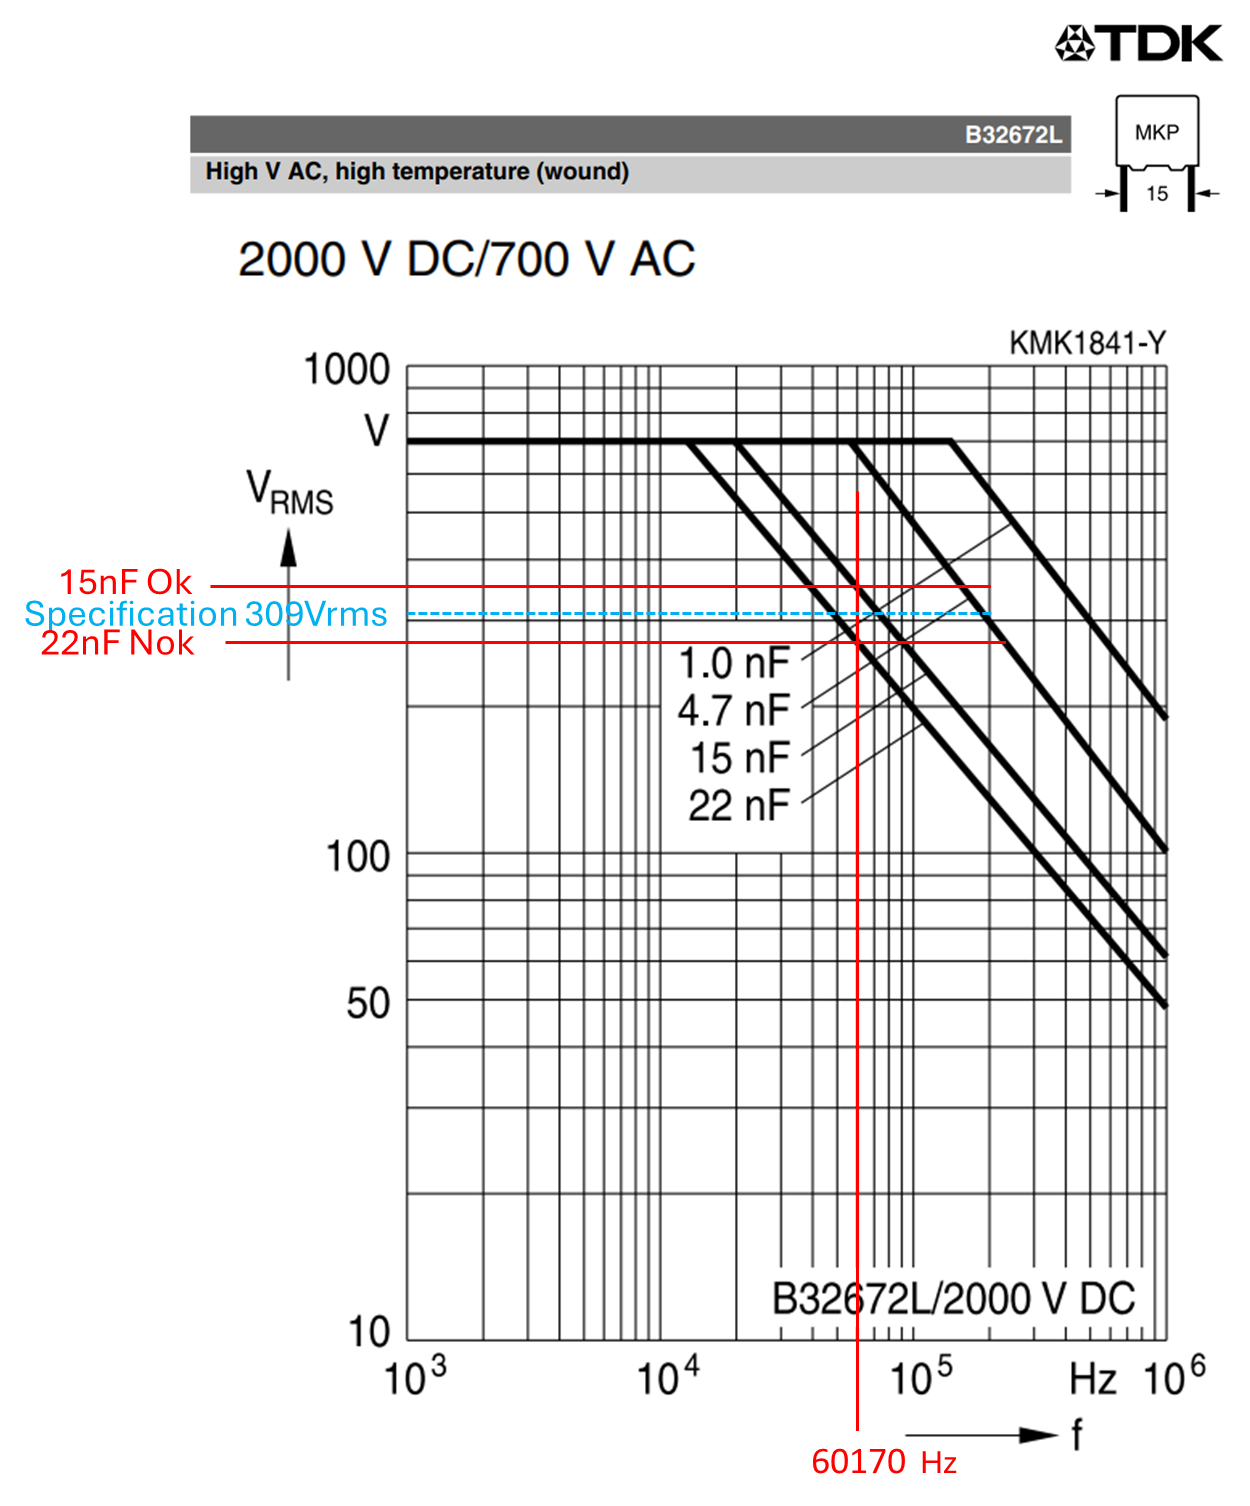

In [ ]:
Ir_rms/8

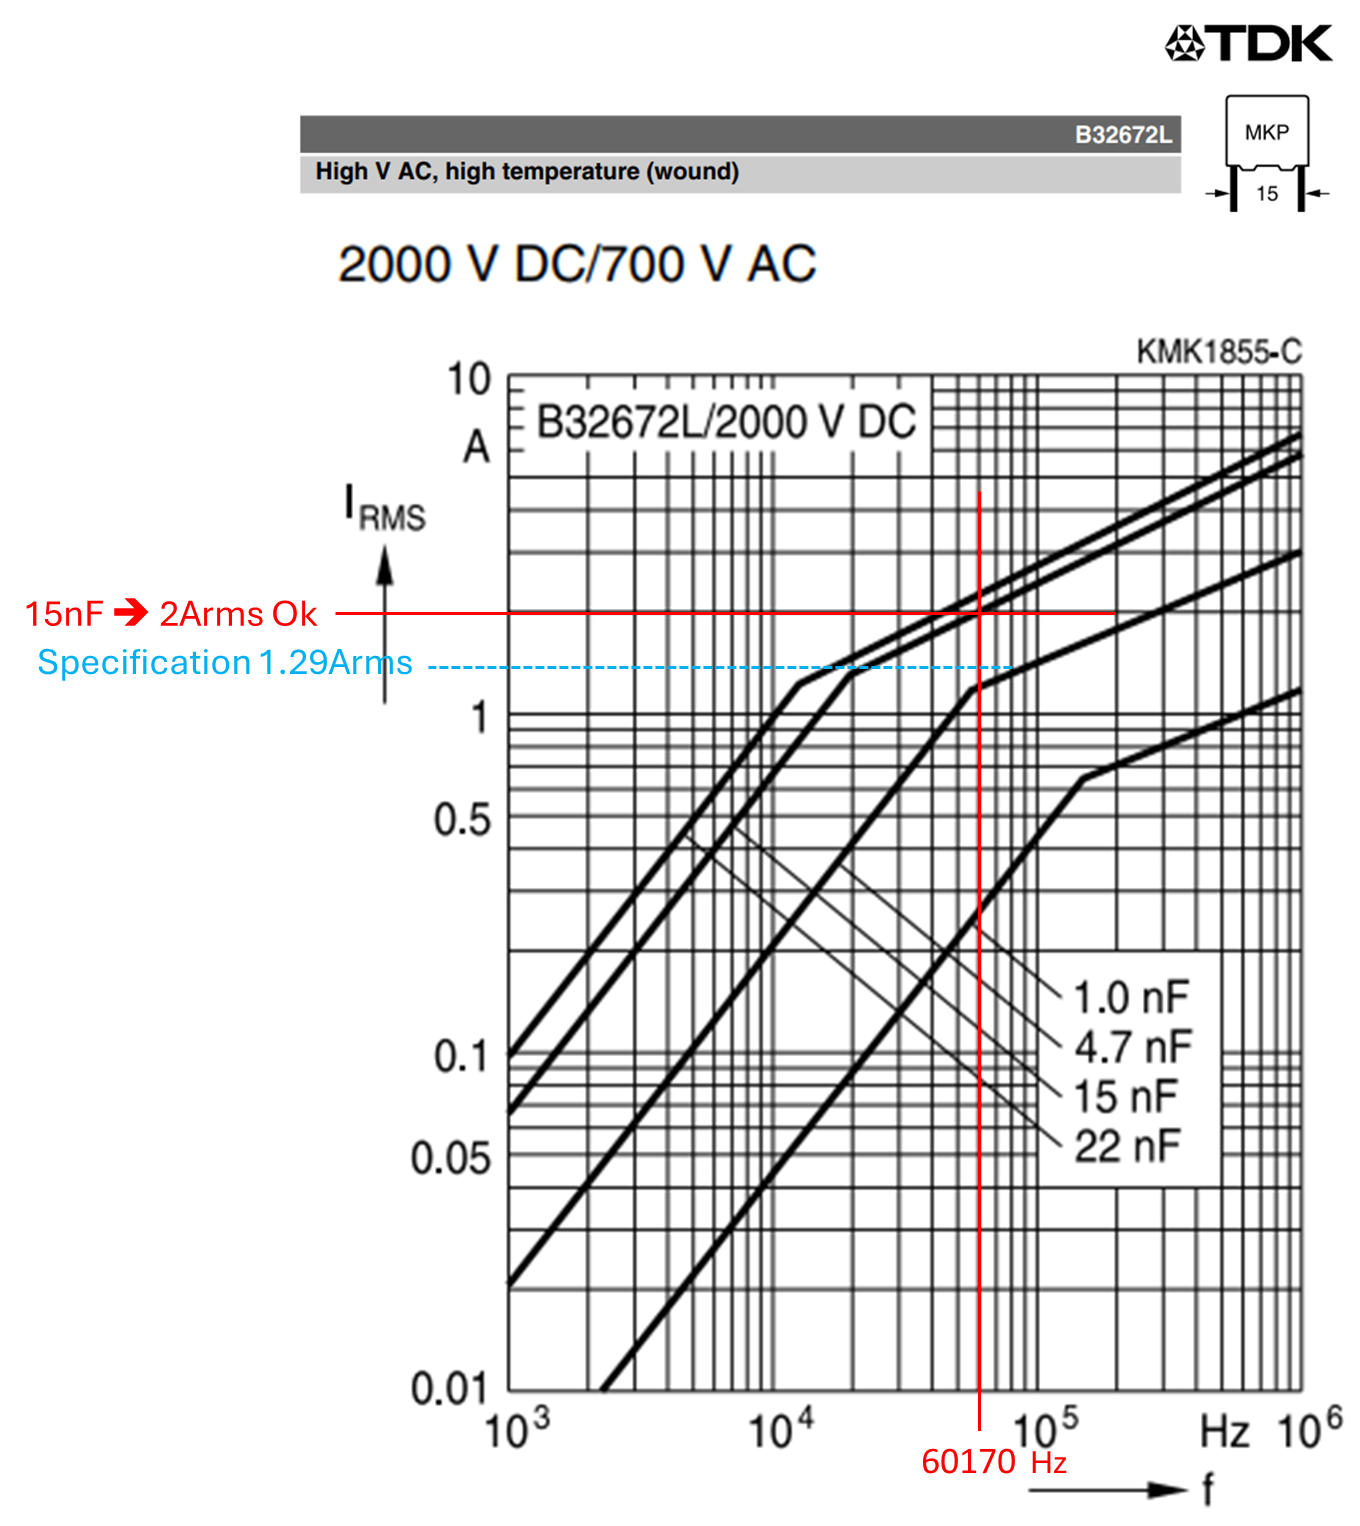

In [ ]:
# https://eu.mouser.com/ProductDetail/EPCOS-TDK/B32672L8153J?qs=CsdphVCLJRjPN7YH24ATpg%3D%3D
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

In [10]:
%%render 
ESR_u= 60# µΩ : around 60 µΩ  for 15nF 

<IPython.core.display.Latex object>

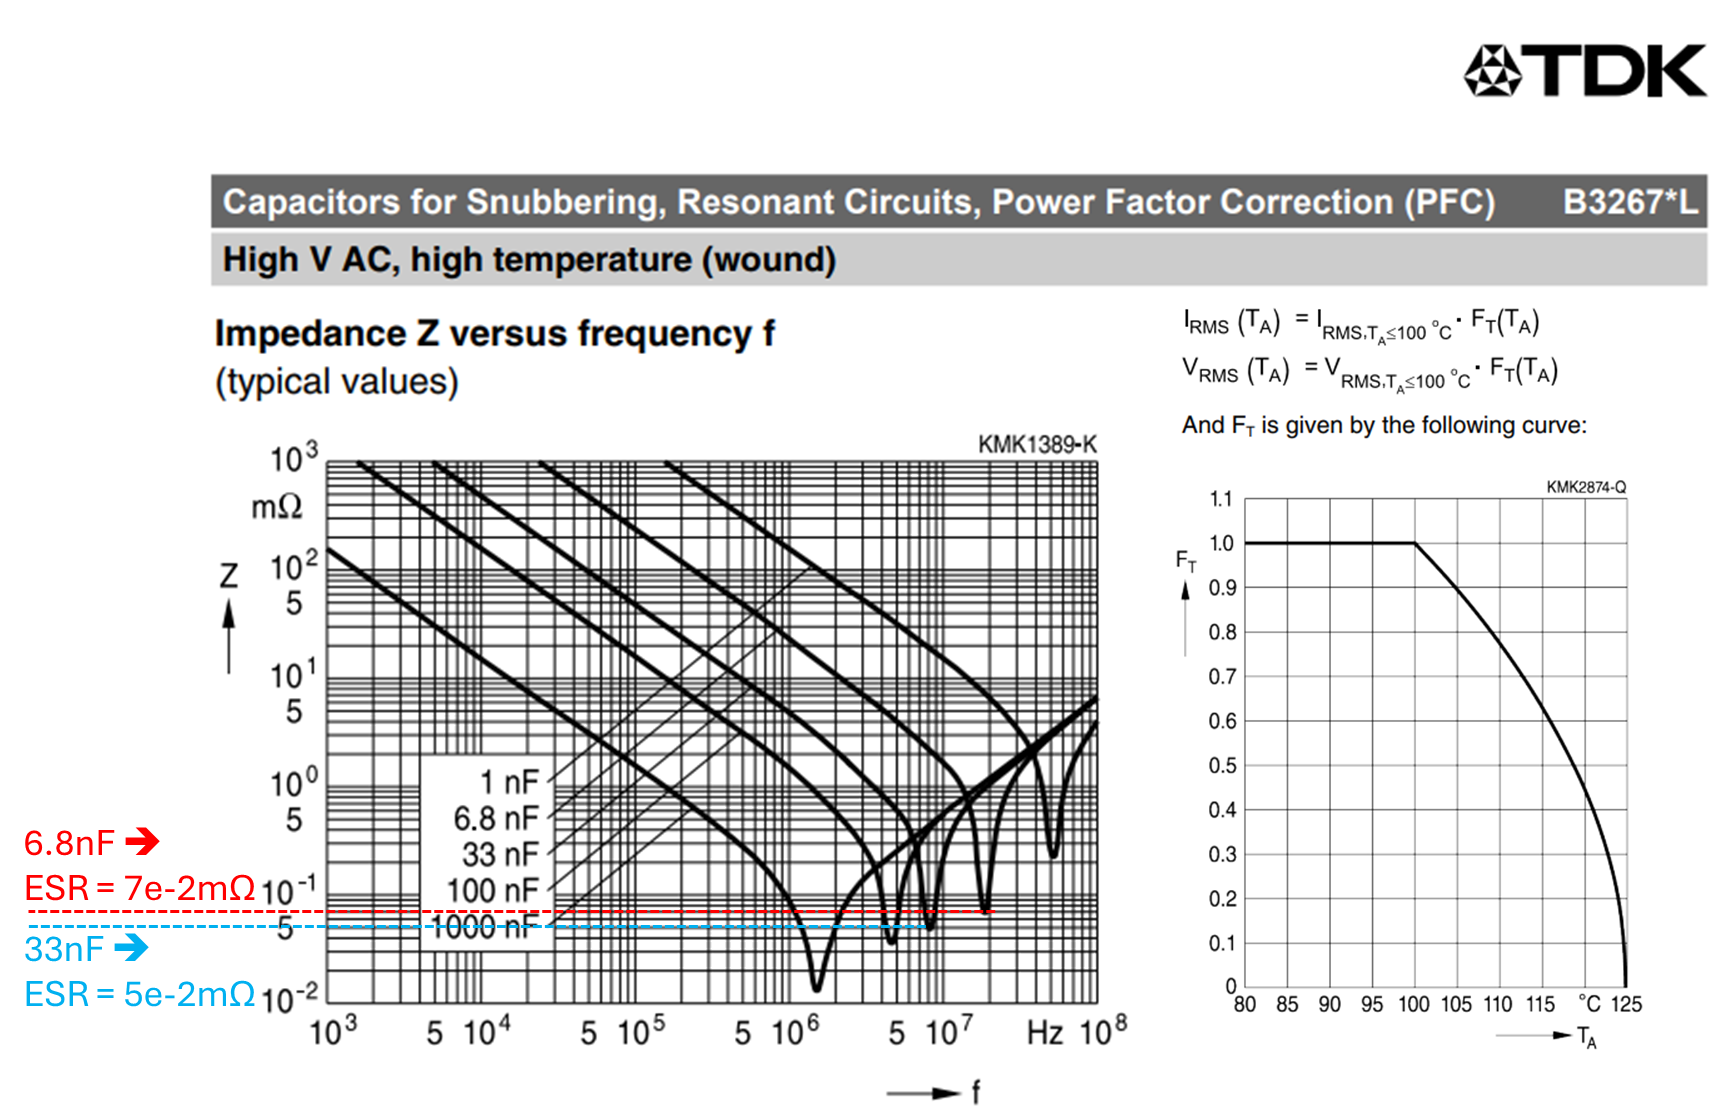

You can donwload the LTSPICE file using this <a src =".\02_simulation\03_Res_capacitor\Comparaison_Res_Capas_Archi.asc">Link</a>.

<img src =".\02_simulation\03_Res_capacitor\Comparaison_Res_Capas_Archi.png">

### Capacitor
27nF
<br>
https://gr.mouser.com/ProductDetail/EPCOS-TDK/B32529C6273J289?qs=3sWhPqbVdzNQE4e4G1wyoQ%3D%3D
<br>
other capacitor
<br>
https://gr.mouser.com/c/passive-components/capacitors/film-capacitors/?capacitance=0.027%20uF&marcom=133880642
<br>
15nF
<br>
https://gr.mouser.com/c/passive-components/capacitors/film-capacitors/?capacitance=0.015%20uF&marcom=133880642
<br>
https://gr.mouser.com/ProductDetail/EPCOS-TDK/B32529C6152J000?qs=Xovllr2ZOuYRH8f69Hao3A%3D%3D

## Dead time to ZVS 

<img src="./03_figs/tdeadZVS.png" style="width:10cm;">

$ t_{\text{dead}} \geq 16 \cdot C_{\text{eq}} \cdot f_{\text{sw}} \cdot L_m $


## References <a class="title_class" id="title_7"></a>

<a id="referencesID1"></a> [1] Hong Huang, *Designing an LLC Resonant
Half-Bridge Power Converter*. Available: [https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf](https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf)
